In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
import pickle

## Carga y preparación inicial del conjunto de datos

In [2]:
file_path = '../data/raw/sales.csv'
data = pd.read_csv(file_path)

# Convertir la columna 'date' a datetime y establecerla como índice
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)

# Seleccionar la serie temporal de ventas
sales_ts = data['sales']

# Mostrar información básica del DataFrame
print("Primeras filas de los datos:")
print(sales_ts.head())
print("\nInformación del DataFrame:")
sales_ts.info()
print(f"\nNúmero de valores nulos: {sales_ts.isnull().sum()}")
print(f"Número de valores duplicados: {sales_ts.duplicated().sum()}")

Primeras filas de los datos:
date
2022-09-03 17:10:08.079328    55.292157
2022-09-04 17:10:08.079328    53.803211
2022-09-05 17:10:08.079328    58.141693
2022-09-06 17:10:08.079328    64.530899
2022-09-07 17:10:08.079328    66.013633
Name: sales, dtype: float64

Información del DataFrame:
<class 'pandas.core.series.Series'>
DatetimeIndex: 366 entries, 2022-09-03 17:10:08.079328 to 2023-09-03 17:10:08.079328
Series name: sales
Non-Null Count  Dtype  
--------------  -----  
366 non-null    float64
dtypes: float64(1)
memory usage: 5.7 KB

Número de valores nulos: 0
Número de valores duplicados: 0


## Análisis de la serie temporal


--- Análisis de la Serie Temporal ---


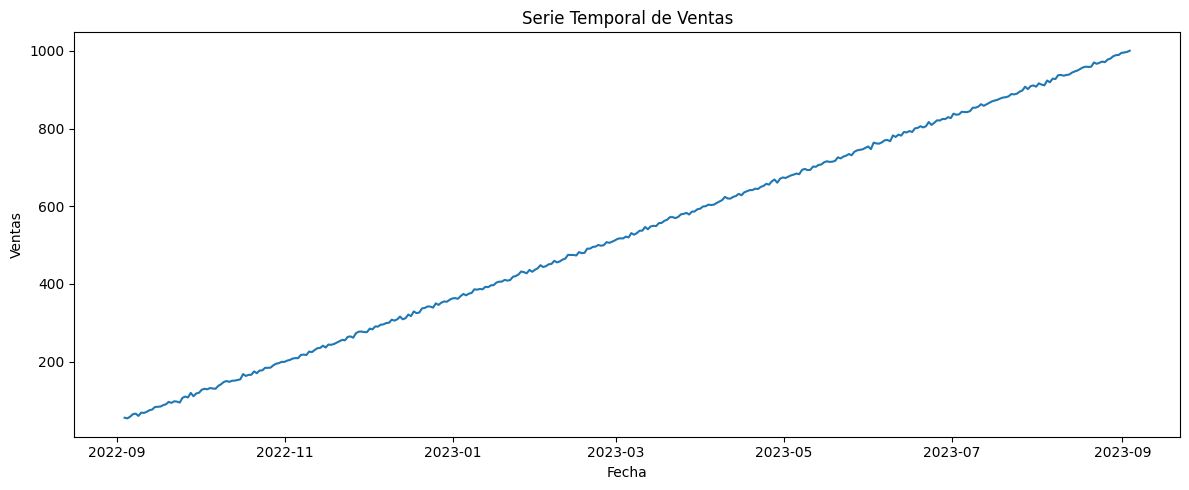


Descomposición de la Serie Temporal:


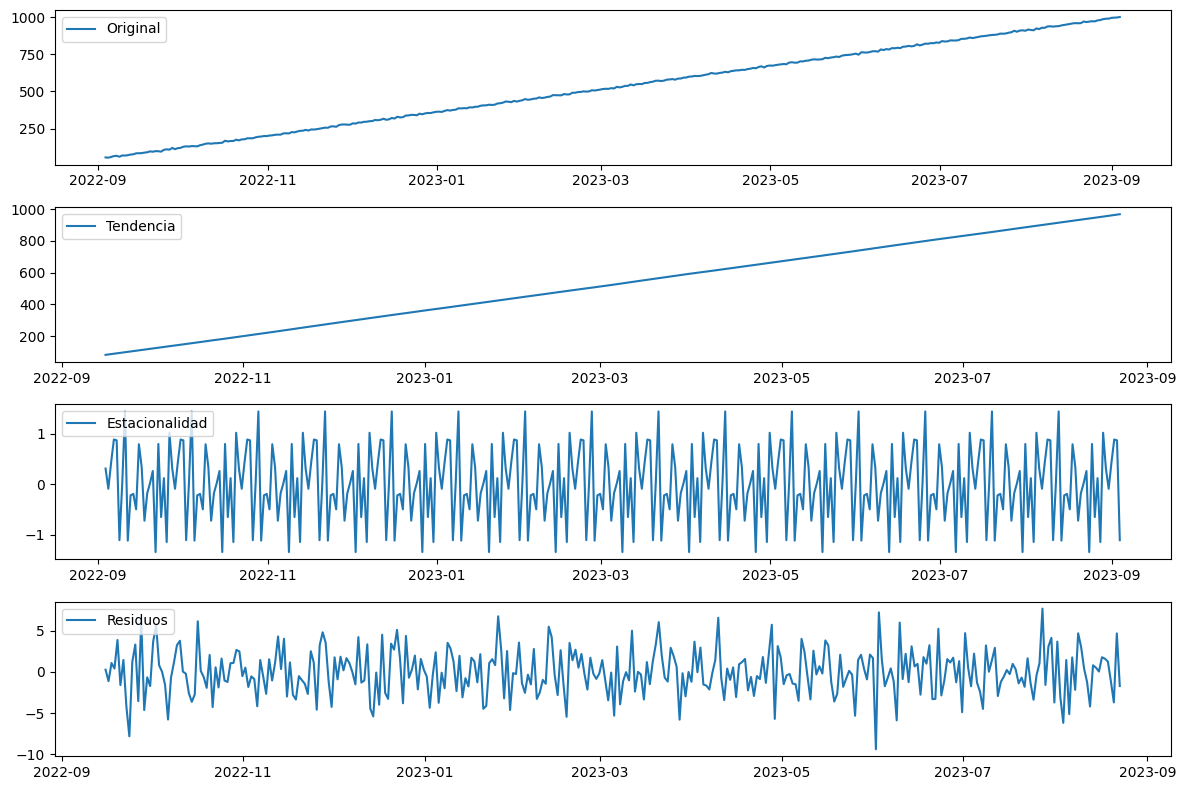


Prueba de Estacionariedad (Dickey-Fuller):
Estadístico ADF: 0.5454
Valor p: 0.9862
Valores críticos:
   1%: -3.4491
   5%: -2.8698
   10%: -2.5712

La serie temporal parece no ser estacionaria.

Gráfico de Autocorrelación (ACF):


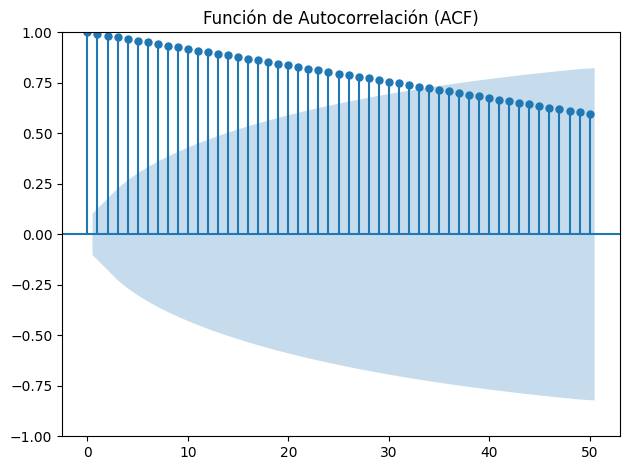

In [3]:
print("\n--- Análisis de la Serie Temporal ---")
# Visualización de la serie temporal
plt.figure(figsize=(12, 5))
sns.lineplot(data=sales_ts)
plt.title('Serie Temporal de Ventas')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.tight_layout()
plt.show()

# Descomposición de la serie temporal
print("\nDescomposición de la Serie Temporal:")
decomposition = seasonal_decompose(sales_ts, period=24)

plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(decomposition.observed, label='Original')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(decomposition.trend, label='Tendencia')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(decomposition.seasonal, label='Estacionalidad')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(decomposition.resid, label='Residuos')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

print("\nPrueba de Estacionariedad (Dickey-Fuller):")
adf_result = adfuller(sales_ts, autolag='AIC')
print(f'Estadístico ADF: {adf_result[0]:.4f}')
print(f'Valor p: {adf_result[1]:.4f}')
print('Valores críticos:')
for key, value in adf_result[4].items():
    print(f'   {key}: {value:.4f}')

if adf_result[1] > 0.05:
    print("\nLa serie temporal parece no ser estacionaria.")
else:
    print("\nLa serie temporal parece ser estacionaria.")

# Análisis de autocorrelación
print("\nGráfico de Autocorrelación (ACF):")
plot_acf(sales_ts, lags=50) # Puedes ajustar el número de lags
plt.title('Función de Autocorrelación (ACF)')
plt.tight_layout()
plt.show()

## Entrenamiento de un modelo ARIMA

In [4]:
from pmdarima import auto_arima

print("\n--- Entrenamiento del Modelo ARIMA ---")

# Hacer la serie estacionaria (si es necesario)
sales_ts_stationary = sales_ts.diff().dropna()

print("\nPrueba de Estacionariedad en la serie diferenciada:")
adf_result_diff = adfuller(sales_ts_stationary, autolag='AIC')
print(f'Estadístico ADF: {adf_result_diff[0]:.4f}')
print(f'Valor p: {adf_result_diff[1]:.4f}')
print('Valores críticos:')
for key, value in adf_result_diff[4].items():
    print(f'   {key}: {value:.4f}')

# Entrenar el modelo auto_arima
model = auto_arima(sales_ts_stationary, seasonal=True, trace=True, m=24)
print(model.summary())

ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

## Paso 4: Predicción

In [ ]:
print("\n--- Predicción con el Modelo ---")
n_predictions = 50
forecast = model.predict(n_predictions)

# Graficar la predicción
plt.figure(figsize=(12, 5))
plt.plot(sales_ts_stationary, label='Serie Temporal Estacionaria Original')
plt.plot(sales_ts_stationary.index[-n_predictions:], forecast, color='green', label='Predicciones')
plt.title('Predicción con Modelo ARIMA')
plt.xlabel('Fecha')
plt.ylabel('Ventas (Diferenciadas)')
plt.legend()
plt.tight_layout()
plt.show()

## Paso 5: Guardar el modelo

In [ ]:
model_path = "../models/Model_auto_arima.pkl"
with open(model_path, "wb") as file:
    pickle.dump(model, file)
print(f"\nModelo guardado en: {model_path}")